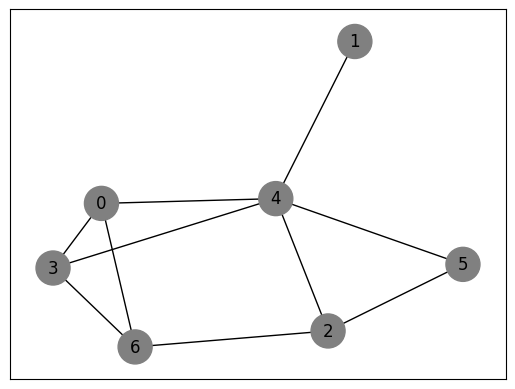

In [297]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import CRYGate, RZZGate, RXGate, PhaseGate
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from scipy.optimize import minimize
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pickle



class UMIS:
    def __init__(self, n, k):
        self.n = n
        self.k = k
        self.qc = QuantumCircuit(n)
    
    def prepare_initial_state(self):
        self.qc.x(range(self.n - self.k, self.n))
        self.qc.barrier()
        #初始状态为Dicke态，限制可行解的演化
        j = self.n  
        while j > 1 and self.k > 0:
            for i in range(self.k):
                if i == 0:
                    self.qc.cx(j - 2 - i, j - 1)
                    self.qc.cry(2 * np.arccos(np.sqrt((i + 1) / j)), j - 1, j - 2 - i)
                    self.qc.cx(j - 2 - i, j - 1)
                else:
                    self.qc.cx(j - 2 - i, j - 1)
                    cry_gate1 = CRYGate(2 * np.arccos(np.sqrt((i + 1) / j))).control(1)
                    self.qc.append(cry_gate1, [j - 1, j - i - 1, j - 2 - i])
                    self.qc.cx(j - 2 - i, j - 1)
            if j == self.k + 1:
                self.k -= 1
            j -= 1
        self.qc.barrier()
        
    # 混合算子：Hb构造
    def apply_mixer_operator(self, beta):
        for i in range(self.n - 1):
           # 泡利XX的作用
          self.qc.rx(np.pi/2, i)
          self.qc.rx(np.pi/2, i + 1)
          self.qc.append(RZZGate(2 * beta), [i, i + 1])
          self.qc.rx(-np.pi/2, i)
          self.qc.rx(-np.pi/2, i + 1)
          # 泡利YY的作用
          self.qc.ry(np.pi/2, i)
          self.qc.ry(np.pi/2, i + 1)
          self.qc.append(RZZGate(2 * beta), [i, i + 1])
          self.qc.ry(-np.pi/2, i)
          self.qc.ry(-np.pi/2, i + 1)
        self.qc.barrier()
        
    # 问题算子：Hc构造  
    def apply_problem_operator(self, weights, edges, gamma):
        for i in range(self.n):
            self.qc.rz(gamma * weights[i] / 2, i)
        # 惩罚项的实现
        for (i, j) in edges:
            weight_sum = (weights[i] + weights[j]) / 4
            self.qc.rz(-gamma * weight_sum, i)
            self.qc.rz(-gamma * weight_sum, j)
            self.qc.append(RZZGate(gamma * weight_sum), [i, j])
        self.qc.barrier()
        
    #CD项电路实现
    def apply_A_operator(self, alpha):
        for (i,j) in edges:
            self.qc.cx(i, j)
            self.qc.h(i)
            self.qc.cx(j,i)
            self.qc.rz(-2 * alpha, i)
            self.qc.cx(j,i)
            self.qc.h(i)
            self.qc.rx(2 * alpha, i)
            self.qc.cx(i, j)
        self.qc.barrier()
        
    def qaoa(self, p, edges, gammas, betas, alphas):
        self.prepare_initial_state()
        for gamma, beta , alpha in zip(gammas, betas, alphas):
            self.apply_problem_operator(weights, edges, gamma)
            self.apply_mixer_operator(beta)
            self.apply_A_operator(alpha)
        self.qc.measure_all()
        return self.qc
        
#XY_CD_mixers的线路构造函数
def RingXY_CD_Circuit(theta):
    p = len(theta) // 3
    betas = theta[:p]
    gammas = theta[p:2*p]
    alphas = theta[2*p:]
    qaoa = UMIS(n, k)
    return qaoa.qaoa(p, edges, gammas, betas, alphas)
    
#期望值的计算函数
def expectation(theta):
    backend = AerSimulator()
    qc = RingXY_CD_Circuit(theta)
    circ = transpile(qc, backend)
    result = backend.run(circ).result()
    counts = result.get_counts(circ)
    cost = 0
    cumulative = 0
    shots = sum(counts.values())
    for bitstring, count in counts.items():
        # 反转比特串，以确保从低位到高位的顺序
        bitstring = bitstring[::-1]
        cost = sum(1 * weights[i] for i in range(n) if bitstring[i] == '1') - sum(1 * (weights[i] + weights[j]) for i, j in edges if bitstring[i] == '1' and bitstring[j] == '1')
        cumulative += cost * count
    return -cumulative / shots

with open('random_graph.pkl', 'rb') as f:
    G, n, p = pickle.load(f)

# 提取图的边集和权重
edges = list(G.edges())  # 读取边集
weights = [G.nodes[node]['weight'] for node in G.nodes()]  # 读取节点权重
k=3 #设置Dicke态的汉明权重数

# 绘制图形
G = nx.Graph()
G.add_nodes_from(range(n))
G.add_edges_from(edges)
colors = ['grey' for _ in range(n)]
default_axes = plt.axes(frameon=True)
pos = nx.spring_layout(G)
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)

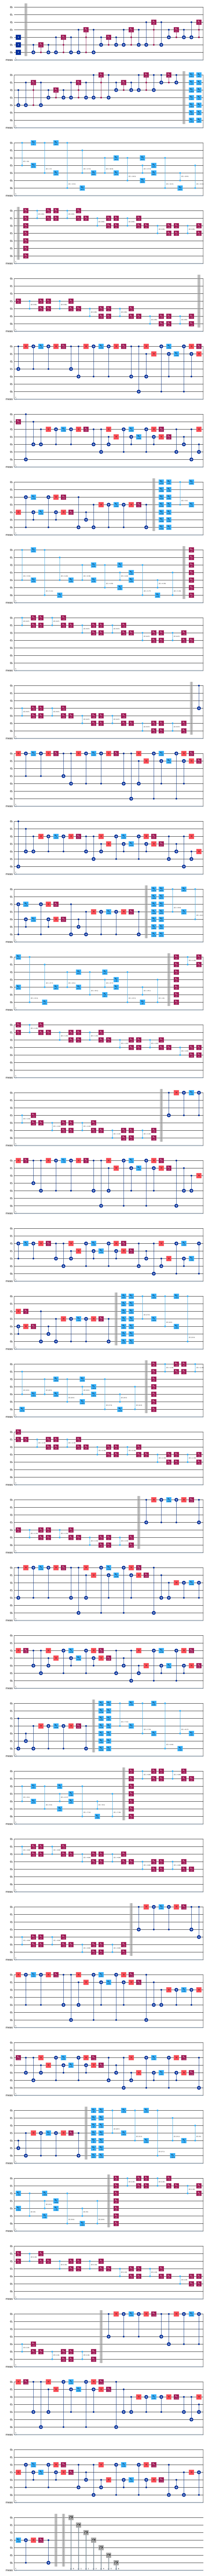

In [298]:
p = 6# QAOA线路迭代层数
beta = np.random.uniform(-np.pi, np.pi, size=p)
gamma = np.random.uniform(-np.pi, np.pi, size=p)
alpa = np.random.uniform(-np.pi, np.pi, size= p)
param = np.concatenate((beta,gamma),axis=0)
param = np.concatenate((alpa,param),axis=0)
# 优化参数
res = minimize(expectation, param, method='COBYLA')
optimal_theta = res.x
# 运行最优电路
final_circuit = RingXY_CD_Circuit(optimal_theta)
backend = AerSimulator()
compiled_circuit = transpile(final_circuit, backend)
result = backend.run(compiled_circuit, shots=10000).result()
counts = result.get_counts(compiled_circuit)
final_circuit.draw('mpl')

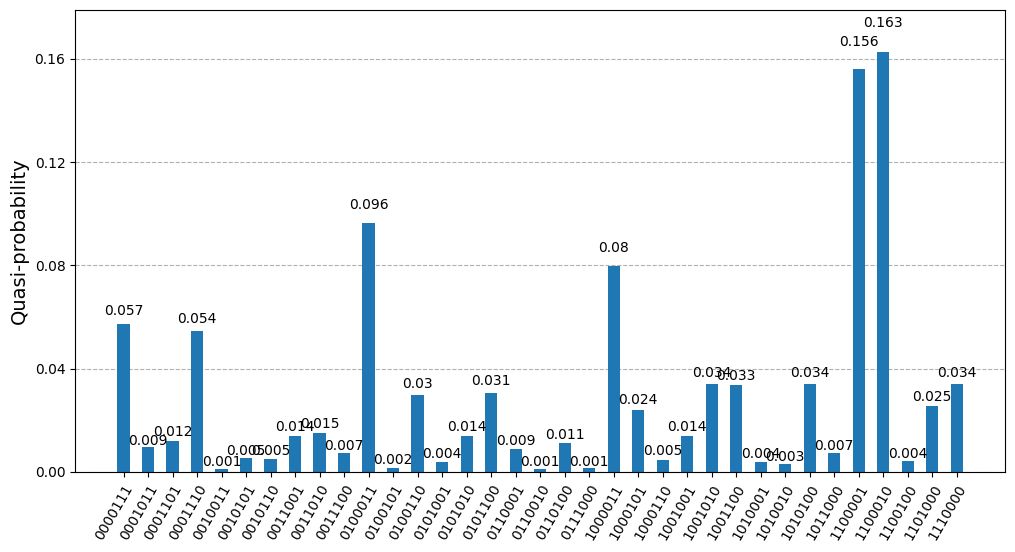

In [299]:
# 绘制直方图
total_counts = sum(counts.values())
#将期望值以百分比的形式展现
# 计算百分比
percentages = {k: v / total_counts * 100 for k, v in counts.items()}
# 使用 plot_histogram 绘制
fig, ax = plt.subplots(figsize=(12, 6))
plot_histogram(percentages, ax=ax) 
# 旋转 x 轴标签
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right", fontsize=10)
plt.show()